The aim of this toy model is to get famialiarized with the use of information-theoretic (IT) measures to estimate connectivity in non-linear models. For instance, this includes network models where the dependency between nodes can be modeled via a quadratic or an abosute-valued function. 

Information theory provides a model-free framework to estimate connectivity under mild assumptions. The computation of information-theoretic measures is typically costly and the cost grows exponentially with the number of variables. However, recent implementations of IT measures via statistical larning techniques (e.g., k-nearest neighbors) have greatly overcome computational limitations. Here we ellaborate 3-node model simulations based on a recent Python toolbox on the Estimation of IT measures(https://bitbucket.org/szzoli/ite-in-python/). 
The presented network configurations can be used to aseess the accuracy of these estimators and can be thought of as building blocks to generalize the analysis to larger networks. 

Specifically, the script generates activity for 3 simple configurations with 3 nodes where nodes are labeled as 'V', 'X' and 'Y'. The different configurations are the following

1) Chain network I:  V-X-Y

2) Chain network II: V-Y-X

3) Common input (V) network: Y-V-X  
                                              
with non-linear functions for each dependency.

These observables generated by each model are the basis for the estiamtion of the Mutual Information (MI) and the conditional Mutual Information (cMI). Non-parametric significance testing is implemented using shuffling of the observed time series for each measure to identify the connections in the original connectivity C.

Refs:
Wikipedia
https://en.wikipedia.org/wiki/Mutual_information
https://en.wikipedia.org/wiki/Conditional_mutual_information
Toolbox
Szabó, Z. (2014). Information theoretical estimators toolbox. The Journal of Machine Learning Research, 15(1), 283-287.http://www.jmlr.org/papers/volume15/szabo14a/szabo14a.pdf


Instructions to use the script:

1-Download the latest release of the ITE toolbox. You can find the .zip folder at the bottom of https://bitbucket.org/szzoli/ite-in-python/.

2-Extract and copy the 'ITE-1.1_code' folder within the 'code' folder of the course working directory. 




# Simulation

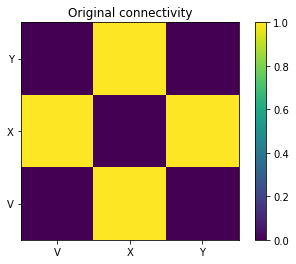

In [70]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as pp
from numpy.random import randn
from numpy import array

#IMPORT ITE TOOLBOX
import sys
sys.path.insert(1, '../code/ITE_code')
import ite

save_figs = True

#Network and simulation parameters 
N = 3 # number of nodes in network
n_net = 3 # number of network configurations to simulate


mask_diag = np.eye(N,dtype=np.bool) # mask for diagonal elements

dim=1 # non-temporal dimension of each time series 

exp_fact=[2,3] # exponents for the non-linear functions
K=0.5# factor of Gaussian noise

T_obs=300 # duration of simulation

# Original network configurations, where C[i,j] is the binary weight from node j to node i
C = np.zeros([N,N]) # connectivity matrices

#SELECTED NETWORK MODEL
selected_network=0

if selected_network==0:
   aux=randn(T_obs,dim)
   V=aux**exp_fact[0]+K*randn(T_obs,1) 
   X=V**exp_fact[0]+K*randn(T_obs,1) 
   Y=X**exp_fact[0]+K*randn(T_obs,1) 
   C[0,1] = 1.
   C[1,0] = 1.
   C[0,2] = 0.
   C[2,0] = 0.
   C[1,2] = 1.
   C[2,1] = 1.
        
# Model 2: Chain network  V-Y-X
if selected_network==1:
   aux=randn(T_obs,dim)
   V=aux**exp_fact[0]+K*randn(T_obs,1) 
   Y=V**exp_fact[0]+K*randn(T_obs,1) 
   X=Y**exp_fact[0]+K*randn(T_obs,1)  
   C[0,1] = 0.
   C[1,0] = 0.
   C[0,2] = 1.
   C[2,0] = 1.
   C[1,2] = 1.
   C[2,1] = 1.
        
    # Model 3: Common-input model V-X
    #                             |
    #                             Y
if selected_network==2:
   aux=randn(T_obs,dim)
   V=aux**exp_fact[0]+K*randn(T_obs,1) 
   X=abs(V)+K*randn(T_obs,1)   
   Y=abs(V)+K*randn(T_obs,1) 
   C[0,1] = 1.
   C[1,0] = 1.
   C[0,2] = 1.
   C[2,0] = 1.
   C[1,2] = 0.
   C[2,1] = 0.
   


pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()
if save_figs:
   pp.savefig('orig_C')
    
pp.show()

# Estimation of Mutual Information (MI) and conditional Mutual Information (cMI)

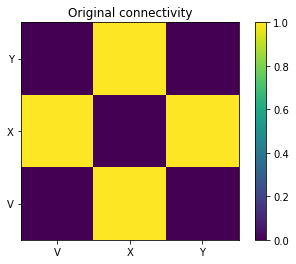

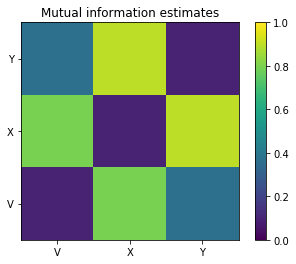

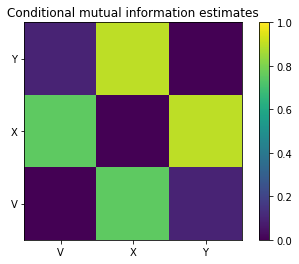

In [71]:
# Mutual Information
#SET VMIN and VMAX for plots

MI=np.zeros([N,N]) #initialize mutual information estimation matrix
co = ite.cost.MIShannon_HS() #Mutual information estimator
ds=array([1,1])#dimension parameters
    
V_X_signals=np.concatenate((V,X), axis=1)
MI[0,1]=co.estimation(V_X_signals, ds)
V_Y_signals=np.concatenate((V,Y), axis=1)
MI[0,2]=co.estimation(V_Y_signals, ds)
X_Y_signals=np.concatenate((X,Y), axis=1)
MI[1,2]=co.estimation(X_Y_signals, ds)
    
MI[1,0]=MI[0,1]
MI[2,0]=MI[0,2]
MI[2,1]=MI[1,2]


#Shift of MI values within interval [0,1]
MI_plot=(0.8*(MI-MI.min()))/(MI.max()-MI.min())+0.1
MI[mask_diag]=0


    
# Conditional Mutual Information
cMI=np.zeros([N,N]) #initialize conditional mutual information estimation matrix
co = ite.cost.BcondIShannon_HShannon()#Conditional mutual information estimator
ds=array([1,1,1])#dimension parameters
    
V_X_Y_signals=np.concatenate((V,X,Y), axis=1)
cMI[0,1]=co.estimation(V_X_Y_signals, ds)
V_Y_X_signals=np.concatenate((V,Y,X), axis=1)
cMI[0,2]=co.estimation(V_Y_X_signals, ds)
X_Y_V_signals=np.concatenate((X,Y,V), axis=1)
cMI[1,2]=co.estimation(X_Y_V_signals, ds)
    
cMI[1,0]=cMI[0,1]
cMI[2,0]=cMI[0,2]
cMI[2,1]=cMI[1,2]

#min_val_cMI=cMI.min()
#max_val_CMI=cMI.max()

#Shift of cMI values within interval [0,1]
cMI_plot=(0.8*(cMI-cMI.min()))/(cMI.max()-cMI.min())+0.1
    
cMI_plot[mask_diag]=0

# plots
pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()

pp.figure()
pp.title('Mutual information estimates')
pp.imshow(MI_plot,interpolation='nearest',origin='bottom',vmin=0, vmax=1) # cmap=pp.cm.bwr)
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()
if save_figs:
    pp.savefig('MI')

pp.figure()
pp.title('Conditional mutual information estimates')
pp.imshow(cMI_plot,interpolation='nearest',origin='bottom', vmin=0, vmax=1) #cmap=pp.cm.bwr
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()
if save_figs:
    pp.savefig('cMI')


pp.show()

# Comparison with Linear measures

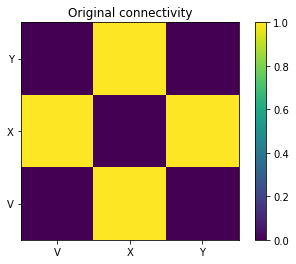

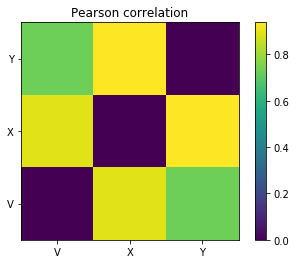

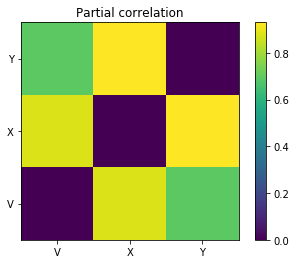

In [72]:
    
    # empirical covariances
    ts_X=np.concatenate((V,X,Y), axis=1)
    Q0 = np.tensordot(ts_X[0:T_obs-1,:],ts_X[0:T_obs-1,:],axes=(0,0)) / (T_obs-2)
    #Q1 = np.tensordot(ts_X[0:nTs-1,:],ts_X[1:nTs,:],axes=(0,0)) / (nTs-2)

    # Pearson correlations
    K = np.array(Q0)
    K /= np.sqrt(np.outer(K.diagonal(),K.diagonal()))
    K[mask_diag] = 0
        
    # partial correlation
    P = np.linalg.pinv(Q0)
    P /= -np.sqrt(np.outer(P.diagonal(),P.diagonal()))
    P[mask_diag] = 0
    
    # plots
pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()


pp.figure()
pp.title('Pearson correlation')
pp.imshow(abs(K),interpolation='nearest',origin='bottom')
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()
if save_figs:
   pp.savefig('CORR')

pp.figure()
pp.title('Partial correlation')
pp.imshow(abs(P),interpolation='nearest',origin='bottom')
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()
if save_figs:
   pp.savefig('PC')
    
pp.show()    

# Non-parametric Significance Testing

To check which estimated values are significantly different from 0, we compare these 
values with surrogates estimates by shuffling the time series.

True positive = hit: 4
False positive = false alarm: 0
False negative = miss: 0
True negative: 5


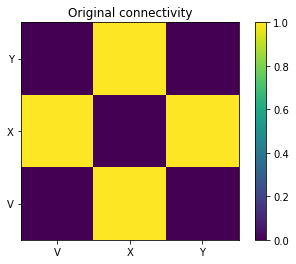

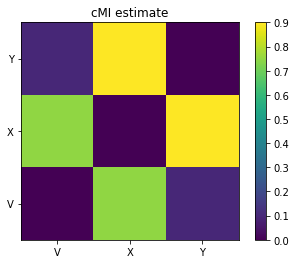

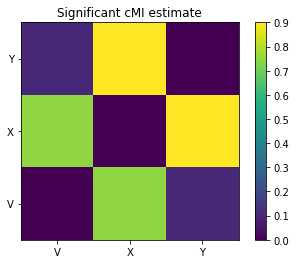

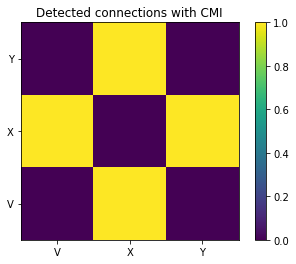

In [74]:
#Shuffling by random permutation of samples within each time series

#Statistical Testing parameters
n_shuf = 100 # number of permutations/shufflings
significance_threshold=0.05; # threshold for signficance testing

#initialization
MI_shuf=np.zeros([n_shuf, N,N])
cMI_shuf=np.zeros([n_shuf, N,N])

#copy of original (non-shuffled) data
ts_non_shuf = np.array(np.concatenate((V,X,Y), axis=1))



for i_shuf in range(n_shuf):
    ts_shuf = np.array(np.concatenate((V,X,Y), axis=1))
    for i in range(N):
        ts_shuf[:,i] = ts_shuf[np.argsort(np.random.rand(T_obs)),i]

    #Mutual Information
    ds=array([1,1])
    co = ite.cost.MIShannon_HS()
    #V_X_signals=np.concatenate((V,X_shuf), axis=1)
    MI_shuf[i_shuf,0,1]=co.estimation(np.concatenate((ts_shuf[:,[0]],ts_non_shuf[:,[1]]), axis=1), ds)
    #V_Y_signals=np.concatenate((V,Y_shuf), axis=1)
    MI_shuf[i_shuf,0,2]=co.estimation(np.concatenate((ts_shuf[:,[0]],ts_non_shuf[:,[2]]), axis=1), ds)
    #X_Y_signals=np.concatenate((X,Y_shuf), axis=1)
    MI_shuf[i_shuf,1,2]=co.estimation(np.concatenate((ts_shuf[:,[1]],ts_non_shuf[:,[2]]), axis=1), ds)
    
    MI_shuf[i_shuf,1,0]=MI_shuf[i_shuf,0,1]
    MI_shuf[i_shuf,2,0]=MI_shuf[i_shuf,0,2]
    MI_shuf[i_shuf,2,1]=MI_shuf[i_shuf,1,2]
    
    MI_shuf[i_shuf,mask_diag]=0
    
    
    # Conditional Mutual Information
    ds=array([1,1,1])
    co = ite.cost.BcondIShannon_HShannon()    
    #V_X_Y_signals=np.concatenate((V_shuf,X_shuf,Y), axis=1)
    cMI_shuf[i_shuf,0,1]=co.estimation(np.concatenate((ts_shuf[:,[0]],ts_non_shuf[:,[1,2]]), axis=1), ds)
    #V_Y_X_signals=np.concatenate((V_shuf,Y_shuf,X), axis=1)
    cMI_shuf[i_shuf,0,2]=co.estimation(np.concatenate((ts_shuf[:,[0]],ts_non_shuf[:,[2,1]]), axis=1), ds)
    #X_Y_V_signals=np.concatenate((X_shuf,Y_shuf,V), axis=1)
    cMI_shuf[i_shuf,1,2]=co.estimation(np.concatenate((ts_shuf[:,[1]],ts_non_shuf[:,[2,0]]), axis=1), ds)
    
    
    cMI_shuf[i_shuf,1,0]=cMI_shuf[i_shuf,0,1]
    cMI_shuf[i_shuf,2,0]=cMI_shuf[i_shuf,0,2]
    cMI_shuf[i_shuf,2,1]=cMI_shuf[i_shuf,1,2]
    
    cMI_shuf[i_shuf,mask_diag]=0
    
    
MI_shuf = np.sort(MI_shuf,axis=0)
# retain only MI estimates that are stronger than 95%
MI_sig = np.zeros(MI.shape)
mask_sig = MI>MI_shuf[-int(n_shuf*significance_threshold),:,:]
MI_sig[mask_sig] = MI[mask_sig]
    
cMI_shuf = np.sort(cMI_shuf,axis=0)
# retain only CMI estimates that are stronger than 95%
cMI_sig = np.array(cMI_plot)
mask_sig = cMI>cMI_shuf[-int(n_shuf*significance_threshold),:,:]
cMI_sig[mask_sig] = cMI_plot[mask_sig]
mask_C = C>0

print('True positive = hit:', np.logical_and(mask_sig,mask_C).sum())
print('False positive = false alarm:', np.logical_and(mask_sig,np.logical_not(mask_C)).sum())
print('False negative = miss:', np.logical_and(np.logical_not(mask_sig),mask_C).sum())
print('True negative:', np.logical_and(np.logical_not(mask_sig),np.logical_not(mask_C)).sum())


# plots
pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()

pp.figure()
pp.title('cMI estimate')
pp.imshow(cMI_plot,interpolation='nearest',origin='bottom')
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()

pp.figure()
pp.title('Significant cMI estimate')
pp.imshow(cMI_sig,interpolation='nearest',origin='bottom')
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()

pp.figure()
pp.title('Detected connections with CMI')
pp.imshow(mask_sig.astype(np.int),interpolation='nearest',origin='bottom')
pp.xticks([0,1,2], ['V', 'X', 'Y'])
pp.yticks([0,1,2], ['V', 'X', 'Y'])
pp.colorbar()
if save_figs:
   pp.savefig('Detected_cMI')
    


pp.show()
    

To check which estimated values are significantly different from 0, we compare these 
values with surrogates estimates by shuffling the time series.